# Import packages

In [1]:
#Data manipulation and visualisation
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#text analytics
import re
import nltk
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

In [7]:
#to see all text in an column
pd.set_option('display.max_colwidth', None)

# Custom functions

In [27]:
#create a set of stop words
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
#remove special characters from text column
def clear_white_space(value):
    regex = re.compile("\s")
    value = regex.sub(" ", value)
    return value

In [3]:
#retain words with only english characters
def get_word(value):
    regex = re.compile(r"[a-zA-Z]+")
    texts = (re.findall(regex, value))
    return ' '.join(texts)

In [4]:
#detect websites for further reference
def get_site(value):
    regex = re.compile("https://[^\s]*\s")
    texts = (re.findall(regex, value))
    return ' '.join(texts)

In [5]:
# #test area for customers functions (to comment out after development)
# test_text = "An aging world: 2015\t0924dD31EAQJ\thttps://www.researchgate.net/profile/Paul-Kowal/publication/299528572_An_Aging_World_2015/links/56fd4be108ae17c8efaa1132/An-Aging-World-2015.pdf\t… of population aging Dr. Suzman played a critical role in developing the aging research … Suzman’s dedication to research on population aging which in his words"
# test_text = clear_white_space(test_text)
# print(test_text)

# site = get_site(test_text)
# print(site)

# test_text = get_word(test_text)
# print(test_text)

# Part 1) Import dataframe

In [6]:
df = pd.read_csv("./google_scholar_aging_data.csv", skiprows = 1, error_bad_lines=False)

b'Skipping line 4: expected 15 fields, saw 18\nSkipping line 24: expected 15 fields, saw 18\nSkipping line 44: expected 15 fields, saw 18\nSkipping line 64: expected 15 fields, saw 18\nSkipping line 84: expected 15 fields, saw 18\nSkipping line 104: expected 15 fields, saw 18\nSkipping line 124: expected 15 fields, saw 18\nSkipping line 144: expected 15 fields, saw 18\nSkipping line 164: expected 15 fields, saw 18\nSkipping line 184: expected 15 fields, saw 18\nSkipping line 204: expected 15 fields, saw 18\nSkipping line 224: expected 15 fields, saw 20\nSkipping line 228: expected 15 fields, saw 22\nSkipping line 235: expected 15 fields, saw 27\nSkipping line 244: expected 15 fields, saw 20\nSkipping line 248: expected 15 fields, saw 22\nSkipping line 255: expected 15 fields, saw 27\nSkipping line 264: expected 15 fields, saw 20\nSkipping line 268: expected 15 fields, saw 22\nSkipping line 275: expected 15 fields, saw 27\nSkipping line 284: expected 15 fields, saw 20\nSkipping line 288

# Part 2: Clean data
1. Retain and combine essential columns
2. Clean text (regular expression operations)



 ### 1) Retain and combine columns with paper's title and abstract 

In [9]:
#get the essential rows that contains titles
df = df.reset_index()
df = df[['level_0', 'level_1', 'level_2']]

In [10]:
#there are 1k+ rows that were repeated
df = df.drop_duplicates(subset=['level_0'])

#some fields are empty. Replace with dumby text. to be removed later 
df["level_1"].fillna("blank", inplace=True)
df["level_2"].fillna("blank", inplace=True)

In [11]:
#combine text columns into single column
df["text"] = df["level_0"] + " " + df["level_1"] + " " + df["level_2"]
df = pd.DataFrame(df["text"])

### 2) Clean text (regular expression operations)

In [14]:
#clear all the white spaces 
df["text"] = df["text"].apply(clear_white_space)

In [15]:
#extract sites into new columns
df["site"] = df["text"].apply(get_site)

In [16]:
#retain full english words in title and abstract
df["text"] = df["text"].apply(get_word)

In [17]:
#convert all words into lower cases for standardisation
df["text"] = df["text"].str.lower()

# Part 3: Sentiment analysis (textblob)
1. Analyse sentiment of all articles
2. Extract top and bottom 15% most "sensational article for word cloud analysis

### 1) Analyse sentiment of all articles 

In [18]:
#create textblob object for each title + abstract prior to analysis
text_list = list(df["text"])

blob_objects = []
for title in text_list:
    blob = TextBlob(title)
    blob_objects.append(blob)

In [19]:
# anaylse sentiment of each textblob object  
sentiment_list = []
for blob in blob_objects:
    sentiment = blob.sentiment.polarity #-1 to 1
    sentiment_list.append(sentiment)

In [20]:
#append sentiment to the respective row in dataframe
sentiment_column = pd.Series(sentiment_list,name ="sentiment")
df = pd.concat([df.reset_index(),sentiment_column.reset_index()],axis="columns")
df = df[[ 'text', 'site',  'sentiment']]

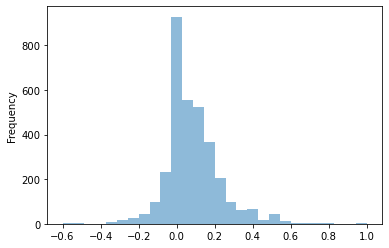

In [21]:
#generate histogram to study distribution of sentiment
ax = df["sentiment"].plot.hist(bins=28, alpha=0.5)

## export graph to pdf
# fig = ax.get_figure()
# fig.savefig('./figure.pdf')

### 2) Extract top and bottom ~15% most "sensational article for word cloud analysis

In [22]:
df_good_news = df[df["sentiment"]>=0.2]
len(df_good_news)/len(df)

0.16501053899427884

In [23]:
df_bad_news = df[df["sentiment"]<-0.0]
len(df_bad_news)/len(df)

0.16621499548328816

# Part 4: Word Cloud for Insights 

## 1) good news 

In [34]:
# count words in title and abstract

#extract columns
text_list = list(df_good_news["text"])

#tokenise the words
for i in range(0,len(text_list)):
    text_list[i] = text_list[i].split(" ")

#file words and counts into dictionary
word_count = {}
for title in text_list:
    for word in title:
        word_count.setdefault(word, 0)
        word_count[word] = word_count[word] + 1 
        
#remove stop words
for key in list(word_count.keys()):
    if key in stopwords:
        word_count.pop(key,None)
        
#remove unwanted words
unwanted_words = ["https","issues","aging","mj","www", "com", 'pdf',"format","file","org", "title",
                 "link", "article", "gov", "html", "j","edu","blank"]
for key in list(word_count.keys()):
    if key in unwanted_words:
        word_count.pop(key,None)

In [35]:
#create working work count dictionary for tuning
word_count_low = word_count.copy()

In [36]:
#tune the word count until reasonably useful information can be extracted
for key in list(word_count_low.keys()):
    if word_count_low[key]>5 or word_count_low[key]<0:
#     if word_count_low[key]>5:
        word_count_low.pop(key,None)


In [37]:
#generate work cloud
word_list = []
for key, value in word_count_low.items():
    for i in range(0,value):
        word_list.append(key)
word_list = " ".join(word_list)

word_cloud_good = WordCloud(background_color = 'white').generate(word_list)
img_good = word_cloud_good.to_image()
img_good.show()

## 2) bed news 

In [88]:
# count words in title and abstract

#extract columns
text_list = list(df_bad_news["text"])

#tokenise the titles
for i in range(0,len(text_list)):
    text_list[i] = text_list[i].split(" ")
    
word_count = {}
for title in text_list:
    for word in title:
        word_count.setdefault(word, 0)
        word_count[word] = word_count[word] + 1 
        
#remove stop words
for key in list(word_count.keys()):
    if key in stopwords:
        word_count.pop(key,None)
        
#remove unwanted words
unwanted_words = ["https","issues","aging","mj","www", "com", 'pdf',"format","file","org", "title",
                 "link", "article", "gov", "html", "j","edu", "articles", "pi","pll","springer","blank"]
for key in list(word_count.keys()):
    if key in unwanted_words:
        word_count.pop(key,None)
        

In [38]:
#create working work count dictionary for tuning
word_count_low = word_count.copy()

In [93]:
#tune the word count until reasonably useful information can be extracted
for key in list(word_count_low.keys()):
    if word_count_low[key]>5 or word_count_low[key]<0:
        word_count_low.pop(key,None)

In [94]:
#generate work cloud
word_list = []
for key, value in word_count_low.items():
    for i in range(0,value):
        word_list.append(key)
word_list = " ".join(word_list)

word_cloud_good = WordCloud(background_color = 'white').generate(word_list)
img_good = word_cloud_good.to_image()
img_good.show()

# Future section (for discussion with the team):
1. Return article URLs for selected keyword
2. Webscrapping module to extract and analyse text from article URLs